
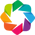

In [1]:
import pandas as pd
import numpy as np
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import cartopy
import cartopy.feature as cf
from cartopy import crs as ccrs

hv.extension('matplotlib', 'bokeh')

%output dpi=120 fig='svg'

Cartopy and shapely make working with geometries and shapes very simple, and GeoViews provides convenient wrappers for the various geometry types they provide. In addition to basic Path and Polygons types, which draw geometries from lists of arrays, GeoViews also provides the ``Feature`` and ``Shape`` types, which wrap cartopy Features and shapely geometries respectively.

### Feature

The Feature Element provides a very convenient means of overlaying a set of basic geographic features on top of or behind a plot. The ``cartopy.feature`` module provides various ways of loading custom features, however geoviews provides a number of default features which we have imported as ``gf``, amongst others this includes coastlines, country borders, and land masses. Here we demonstrate how we can plot these very easily, either in isolation or overlaid:

In [2]:
(gf.ocean + gf.land + gf.ocean * gf.land * gf.coastline * gf.borders).cols(3)

C:\ProgramData\Anaconda3\envs\MPO624_hologeo\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\ProgramData\Anaconda3\envs\MPO624_hologeo\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\ProgramData\Anaconda3\envs\MPO624_hologeo\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


:Layout
   .Ocean.I   :Feature   [Longitude,Latitude]
   .Land.I    :Feature   [Longitude,Latitude]
   .Overlay.I :Overlay
      .Ocean.I     :Feature   [Longitude,Latitude]
      .Land.I      :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]

These deafult features simply wrap around cartopy Features, therefore we can easily load a custom ``NaturalEarthFeature`` such as graticules at 30 degree intervals: 

In [3]:
%%opts Feature.Lines [projection=ccrs.Robinson()] (facecolor='none' edgecolor='gray')
graticules = cf.NaturalEarthFeature(
    category='physical',
    name='graticules_30',
    scale='110m')
(gf.ocean * gf.land() * gv.Feature(graticules, group='Lines') * gf.borders * gf.coastline)

C:\ProgramData\Anaconda3\envs\MPO624_hologeo\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_graticules_30.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Land.I      :Feature   [Longitude,Latitude]
   .Lines.I     :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]

The scale of features may be controlled using the ``scale`` plot option, the most common options being `'10m'`, `'50m'` and `'110m'`. Cartopy will downloaded the requested resolution as needed.

In [4]:
%%output backend='bokeh'
%%opts Feature.Land.110m [scale='110m']
%%opts Feature.Land.50m [scale='50m']
(gf.ocean * gf.land().relabel(label='110m') * gv.Feature(graticules, group='Lines') + 
     gf.ocean * gf.land().relabel(label='50m') * gv.Feature(graticules, group='Lines'))

C:\ProgramData\Anaconda3\envs\MPO624_hologeo\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


:Layout
   .Overlay.I  :Overlay
      .Ocean.I     :Feature   [Longitude,Latitude]
      .Land.A_110m :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
   .Overlay.II :Overlay
      .Ocean.I    :Feature   [Longitude,Latitude]
      .Land.A_50m :Feature   [Longitude,Latitude]
      .Lines.I    :Feature   [Longitude,Latitude]

zoom in using the bokeh zoom widget and you should see that the right hand panel is using a higher resultion dataset for the land feature

### Shape

The ``gv.Shape`` object wraps around any shapely geometry, allowing finer grained control over each polygon. We can, for example, access the geometries on the ``LAND`` feature and display them individually. Here we will get the geometry corresponding to the Australian continent and display it using shapely's inbuilt SVG repr (not yet a HoloViews plot, just a bare SVG displayed by Jupyter directly):

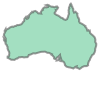

In [5]:
land_geoms = list(gf.land.data.geometries())
land_geoms[21]

Instead of letting shapely render it as an SVG, we can now wrap it in the ``gv.Shape`` object and let matplotlib or bokeh render it, alone or with other GeoViews or HoloViews objects:

In [6]:
%%opts Points (color="black")
australia = gv.Shape(land_geoms[21], crs=ccrs.PlateCarree())

australia * gv.Points([(133.870,-23.700)]) * gv.Text(133.870,-21.5, 'Alice Springs', crs=ccrs.PlateCarree())

:Overlay
   .Shape.I  :Shape   [Longitude,Latitude]   (Level)
   .Points.I :Points   [Longitude,Latitude]
   .Text.I   :Text   [x,y]

We can also iterate over the geometries and wrap them all in an NdOverlay of ``gv.Shape`` Elements:

In [7]:
%%opts NdOverlay [aspect=2]
hv.NdOverlay({i: gv.Shape(s, crs=ccrs.PlateCarree()) for i, s in enumerate(land_geoms)})

:NdOverlay   [Element]
   :Shape   [Longitude,Latitude]   (Level)

This makes it possible to create choropleth maps, where each part of the geometry is assigned a value that will be used to color it. However, constructing a choropleth by combining a bunch of shapes can be a lot of effort and is error prone. For that reason, the Shape Element provides convenience methods to load geometries from a shapefile. Here we load the boundaries of UK electoral districts directly from an existing shapefile:

In [8]:
shapefile = './assets/boundaries/boundaries.shp'
gv.Shape.from_shapefile(shapefile, crs=ccrs.PlateCarree())

ShapefileException: Unable to open ./assets/boundaries/boundaries.dbf or ./assets/boundaries/boundaries.shp.

To combine these shapes with some actual data, we have to be able to merge them with a dataset. To do so we can inspect the records the cartopy shapereader loads:

In [ ]:
shapes = cartopy.io.shapereader.Reader(shapefile)
list(shapes.records())[0]

As we can see, the record contains a ``MultiPolygon`` together with a standard geographic ``code``, which we can use to match up the geometries with a dataset. To continue we will require a dataset that is also indexed by these codes. For this purpose we load a dataset of the 2016 EU Referendum result in the UK:

In [ ]:
referendum = pd.read_csv('./assets/referendum.csv')
referendum = hv.Dataset(referendum)
referendum.data.head()

The ``from_records`` function optionally also supports merging the records and dataset directly. To merge them, supply the name of the shared attribute on which the merge is based via the ``on`` argument. If the name of attribute in the records and the dimension in the dataset match exactly, you can simply supply it as a string, otherwise supply a dictionary mapping between the attribute and column name. In this case we want to color the choropleth by the `'leaveVoteshare'`, which we define via the `value` argument. By default, the resulting `NdOverlay` of shapes will be indexed by an integer index. To draw the index from values in the dataset instead, you can request one or more indexes using the ``index`` argument. Finally we will declare the coordinate reference system in which this data is stored, which will in most cases be the simple Plate Carree projection.  We can then view the choropleth, with each shape colored by the specified value (the percentage who voted to leave the EU):

In [ ]:
%%output backend='bokeh'
%%opts Shape (cmap='viridis')
gv.Shape.from_records(shapes.records(), referendum, on='code', value='leaveVoteshare',
                     index=['name', 'regionName'], crs=ccrs.PlateCarree())

## GeoPandas

GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types, which makes it a very convenient way of working with geometries with associated variables. GeoViews ``Path``, ``Contours`` and ``Polygons`` Elements natively support projecting and plotting of
geopandas DataFrames using both ``matplotlib`` and ``bokeh`` plotting extensions. We will load the example dataset of the world which also includes some additional data about each country:

In [ ]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

We can simply pass the GeoPandas DataFrame to a Polygons, Path or Contours element and it will plot the data for us. The ``Contours`` and ``Polygons`` will automatically color the data by the first specified value dimension defined by the ``vdims`` keyword (the geometries may be colored by any dimension using the ``color_index`` plot option):

In [9]:
%%opts Polygons [projection=ccrs.Robinson() fig_size=250]
gv.Polygons(world, vdims='pop_est')

NameError: name 'world' is not defined

Geometries can be displayed using both matplotlib and bokeh, here we will switch to bokeh allowing us to color by a categorical variable (``continent``) and activating the hover tool to reveal information about the plot.

In [ ]:
%%output backend='bokeh'
%%opts Polygons [width=600 height=500 tools=['hover']] (cmap='tab20')
gv.Polygons(world, vdims=['continent',  'name', 'pop_est']).redim.range(Latitude=(-60, 90))

The "Working with Bokeh" GeoViews notebook shows how to enable hover data that displays information about each of these shapes interactively.